In [1]:
import os

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns


In [2]:
# 1. Connection Config
# Polars prefers a direct URI string over a SQLAlchemy engine object
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

In [3]:
# 2. Load Data (Lazy is not supported for DB read yet, but eager is very fast)
# We sample significantly more data than Pandas could handle easily
query = """
SELECT 
    pickup_location_id,
    dropoff_location_id,
    pickup_datetime,
    trip_distance,
    total_amount
FROM dbt_dev.fct_trips
WHERE total_amount > 0 
  AND total_amount < 200 
  AND trip_distance > 0
LIMIT 500000
"""

print("Loading data with Polars...")
df = pl.read_database_uri(query=query, uri=uri, engine="connectorx")
print(f"Loaded {df.height} rows.")

Loading data with Polars...
Loaded 500000 rows.


In [4]:
# 3. Feature Engineering (The Polars Way)
# Using Polars expressions is much faster than .apply()
df_clean = df.with_columns([
    pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
    pl.col("pickup_datetime").dt.weekday().alias("pickup_day"), # 1=Mon, 7=Sun
    # Calculate approx duration if you had dropoff_time, or any other FE
])

In [5]:
# 4. Correlation Analysis
# We select numeric columns and calculate correlation
corr_df = df_clean.select([
    "trip_distance", "total_amount", "pickup_hour", "pickup_day"
]).corr()
print(corr_df)

shape: (4, 4)
┌───────────────┬──────────────┬─────────────┬────────────┐
│ trip_distance ┆ total_amount ┆ pickup_hour ┆ pickup_day │
│ ---           ┆ ---          ┆ ---         ┆ ---        │
│ f64           ┆ f64          ┆ f64         ┆ f64        │
╞═══════════════╪══════════════╪═════════════╪════════════╡
│ 1.0           ┆ 0.852576     ┆ 0.000344    ┆ 0.001213   │
│ 0.852576      ┆ 1.0          ┆ 0.024148    ┆ -0.006608  │
│ 0.000344      ┆ 0.024148     ┆ 1.0         ┆ 0.100391   │
│ 0.001213      ┆ -0.006608    ┆ 0.100391    ┆ 1.0        │
└───────────────┴──────────────┴─────────────┴────────────┘


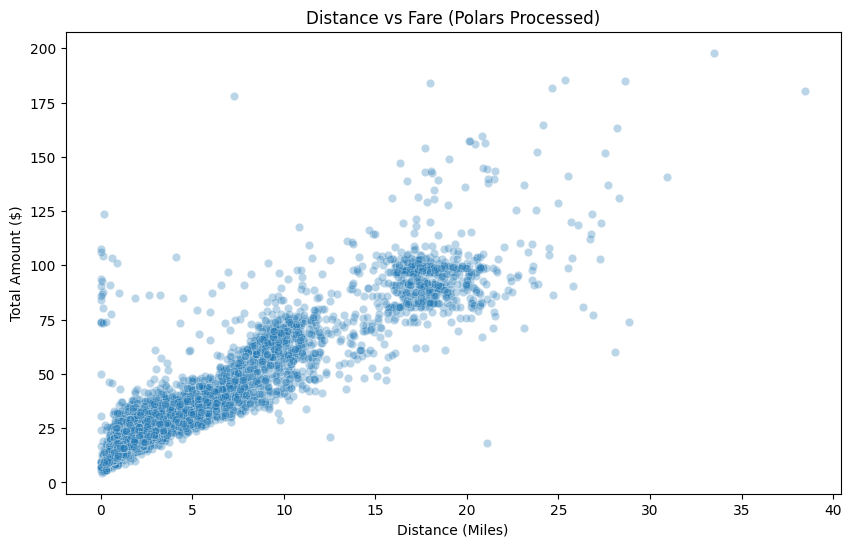

In [6]:
# 5. Visualization (Downsample for plotting)
# We sample 10k rows and convert to Pandas for Seaborn
plot_data = df_clean.sample(10000).to_pandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='trip_distance', y='total_amount', alpha=0.3)
plt.title("Distance vs Fare (Polars Processed)")
plt.xlabel("Distance (Miles)")
plt.ylabel("Total Amount ($)")
plt.show()

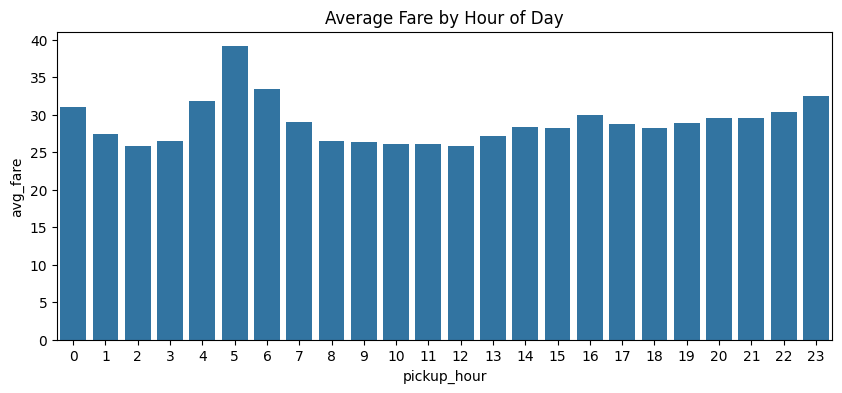

In [7]:
# 6. Demand by Hour
hourly_stats = df_clean.group_by("pickup_hour").agg(
    pl.col("total_amount").mean().alias("avg_fare"),
    pl.col("total_amount").count().alias("trip_count")
).sort("pickup_hour").to_pandas()

plt.figure(figsize=(10, 4))
sns.barplot(data=hourly_stats, x='pickup_hour', y='avg_fare')
plt.title("Average Fare by Hour of Day")
plt.show()